In [1]:
# %%
# 导入基础库
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 导入PyTorch相关库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, datasets
from torchvision.models import swin_t, Swin_T_Weights

# 设置随机种子，确保可复现性
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 检查CUDA设备
if torch.cuda.is_available():
    print(f"当前CUDA设备: {torch.cuda.get_device_name(0)}")
    print(f"CUDA版本: {torch.version.cuda}")


使用设备: cuda
当前CUDA设备: NVIDIA GeForce RTX 3090
CUDA版本: 11.8


In [2]:
# %%
# 项目配置
class Config:
    # 数据集配置
    DATA_PATH = '/mnt/MCP/hagrid_classification'
    CLASSES = ['call', 'fist', 'like', 'ok', 'one', 'palm', 'rock', 'three', 'two_up']
    NUM_CLASSES = len(CLASSES)
    
    # 模型配置
    MODEL_NAME = 'Swin-T'  # Swin Transformer Tiny
    INPUT_SIZE = (3, 224, 224)
    USE_PRETRAINED = True
    
    # 训练配置
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.0001  # Swin Transformer通常使用较小的学习率
    WEIGHT_DECAY = 0.05     # Swin Transformer通常使用较大的权重衰减
    NUM_WORKERS = 4
    
    # 早停配置
    PATIENCE = 15
    MIN_DELTA = 0.001
    
    # 模型保存路径
    MODEL_SAVE_DIR = './models'
    BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'best_swin_gesture_model.pth')
    FINAL_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'final_swin_gesture_model.pth')

# 创建保存模型的目录
if not os.path.exists(Config.MODEL_SAVE_DIR):
    os.makedirs(Config.MODEL_SAVE_DIR)

# 检查数据集路径是否存在
if not os.path.exists(Config.DATA_PATH):
    print(f"警告: 数据路径 {Config.DATA_PATH} 不存在，请确认数据集路径！")
else:
    print(f"数据集路径已确认: {Config.DATA_PATH}")
    train_dir = os.path.join(Config.DATA_PATH, 'train')
    val_dir = os.path.join(Config.DATA_PATH, 'val')
    
    if os.path.exists(train_dir):
        print(f"训练集目录: {train_dir}")
    if os.path.exists(val_dir):
        print(f"验证集目录: {val_dir}")


数据集路径已确认: /mnt/MCP/hagrid_classification
训练集目录: /mnt/MCP/hagrid_classification/train
验证集目录: /mnt/MCP/hagrid_classification/val


训练集大小: 204187
验证集大小: 26990
类别映射: {'call': 0, 'fist': 1, 'like': 2, 'ok': 3, 'one': 4, 'palm': 5, 'rock': 6, 'three': 7, 'two_up': 8}


/tmp/ipykernel_50413/2734914734.py:127: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/2734914734.py:127: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


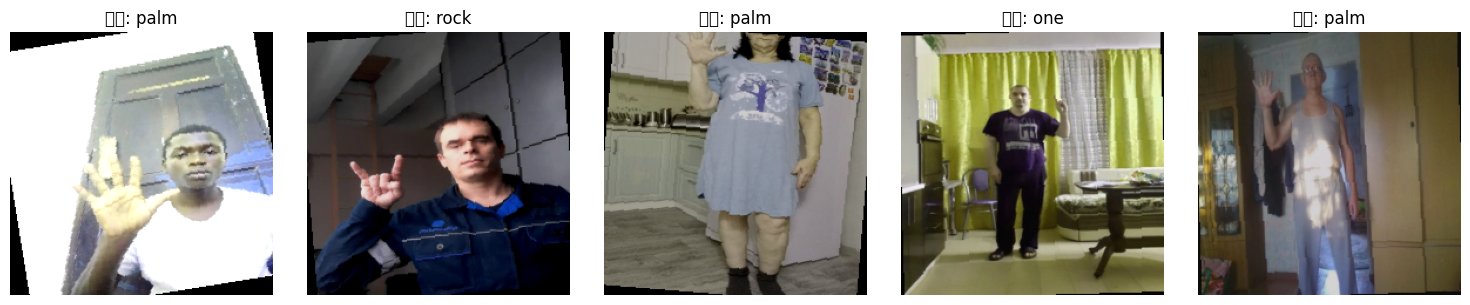

In [3]:
# %%
# 定义数据增强和转换
def get_data_transforms():
    """
    创建训练和验证数据集的转换流水线
    Swin Transformer推荐的预处理方式
    
    返回:
        train_transforms, val_transforms: 两个转换对象
    """
    # Swin Transformer使用的均值和标准差（ImageNet标准）
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # 训练数据增强
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to slightly larger dimension
        transforms.RandomCrop(224),     # Random crop to target size
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),  
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    # 验证数据转换
    val_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),     # Center crop for validation
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    return train_transforms, val_transforms

# 加载并预处理数据集
def load_datasets():
    """
    加载并预处理训练集和验证集
    
    返回:
        train_dataset, val_dataset: 两个数据集对象
    """
    # 获取数据转换
    train_transforms, val_transforms = get_data_transforms()
    
    # 加载数据集
    train_dataset = datasets.ImageFolder(
        root=os.path.join(Config.DATA_PATH, 'train'),
        transform=train_transforms
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(Config.DATA_PATH, 'val'),
        transform=val_transforms
    )
    
    # 输出数据集信息
    print(f"训练集大小: {len(train_dataset)}")
    print(f"验证集大小: {len(val_dataset)}")
    print(f"类别映射: {train_dataset.class_to_idx}")
    
    return train_dataset, val_dataset

# 创建数据加载器
def create_data_loaders(train_dataset, val_dataset):
    """
    为训练集和验证集创建数据加载器
    
    参数:
        train_dataset: 训练数据集
        val_dataset: 验证数据集
    返回:
        train_loader, val_loader: 两个数据加载器
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True
    )
    
    return train_loader, val_loader

# 执行数据加载
train_dataset, val_dataset = load_datasets()
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset)

# 可视化一些训练样本
def visualize_samples(dataset, num_samples=5):
    """可视化数据集的样本"""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    # 反标准化函数
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return torch.clamp(tensor * std + mean, 0, 1)
    
    for i in range(num_samples):
        # 随机选择样本
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        
        # 反标准化图像
        img = denormalize(img)
        
        # 显示图像
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"类别: {Config.CLASSES[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 可视化一些样本
visualize_samples(train_dataset)


In [4]:
# %%
# 定义基于Swin Transformer的手势识别模型
class GestureSwinTransformer(nn.Module):
    """
    基于Swin Transformer的手势识别模型
    """
    
    def __init__(self, num_classes=9, use_pretrained=True):
        """
        初始化Swin Transformer模型
        
        参数:
            num_classes (int): 类别数量
            use_pretrained (bool): 是否使用预训练权重
        """
        super(GestureSwinTransformer, self).__init__()
        
        # 加载预训练的Swin-T模型
        if use_pretrained:
            # 使用正确的预训练权重格式
            weights = Swin_T_Weights.IMAGENET1K_V1
            self.swin_model = swin_t(weights=weights)
            print("加载预训练的Swin-T模型（ImageNet权重）")
        else:
            self.swin_model = swin_t(weights=None)
            print("初始化Swin-T模型（无预训练权重）")
        
        # 修改分类头以匹配我们的类别数
        num_features = self.swin_model.head.in_features
        self.swin_model.head = nn.Linear(num_features, num_classes)
        
        # 添加Dropout层防止过拟合
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        """前向传播"""
        x = self.swin_model(x)
        x = self.dropout(x)
        return x

# 初始化模型
def initialize_model():
    """
    初始化并配置手势识别Swin Transformer模型
    
    返回:
        model: 配置好的模型
    """
    # 创建模型
    model = GestureSwinTransformer(
        num_classes=Config.NUM_CLASSES,
        use_pretrained=Config.USE_PRETRAINED
    )
    
    # 将模型移到指定设备
    model = model.to(device)
    
    # 统计模型参数
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"总参数量: {total_params:,}")
    print(f"可训练参数量: {trainable_params:,}")
    
    return model

# 初始化模型
model = initialize_model()

# 打印模型架构简要信息
print(model)


Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:13<00:00, 8.20MB/s] 


加载预训练的Swin-T模型（ImageNet权重）
总参数量: 27,526,275
可训练参数量: 27,526,275
GestureSwinTransformer(
  (swin_model): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_fe

In [5]:
# %%
# 定义损失函数和优化器
def configure_training(model):
    """
    配置训练所需的损失函数、优化器和学习率调度器
    Swin Transformer通常需要特定的训练配置
    
    参数:
        model: 要训练的模型
    返回:
        criterion, optimizer, scheduler: 损失函数、优化器和学习率调度器
    """
    # 损失函数：交叉熵损失（适用于多分类问题）
    criterion = nn.CrossEntropyLoss()
    
    # 优化器：AdamW优化器，通常用于Transformer模型
    optimizer = optim.AdamW(
        model.parameters(),
        lr=Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY
    )
    
    # 学习率调度器：余弦退火，随着训练的进行逐渐降低学习率
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=Config.NUM_EPOCHS
    )
    
    return criterion, optimizer, scheduler

# 配置训练组件
criterion, optimizer, scheduler = configure_training(model)

# 定义早停机制
class EarlyStopping:
    """早停机制，防止过拟合"""
    
    def __init__(self, patience=15, min_delta=0.001):
        """
        初始化早停对象
        
        参数:
            patience (int): 容忍的epoch数
            min_delta (float): 最小改善阈值
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        """
        调用以更新早停状态
        
        参数:
            val_loss (float): 当前验证损失
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# 初始化早停机制
early_stopping = EarlyStopping(
    patience=Config.PATIENCE,
    min_delta=Config.MIN_DELTA
)


In [6]:
# %%
# 训练和验证函数
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    训练模型一个epoch
    
    参数:
        model: 模型
        dataloader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 计算设备
    
    返回:
        epoch_loss, epoch_acc: 该epoch的平均损失和准确率
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用tqdm显示进度条
    pbar = tqdm(dataloader, desc="训练中")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播
        loss.backward()
        
        # 参数更新
        optimizer.step()
        
        # 累计损失
        running_loss += loss.item() * inputs.size(0)
        
        # 计算准确率
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 更新进度条
        pbar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })
    
    # 计算整个epoch的平均损失和准确率
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """
    验证模型性能
    
    参数:
        model: 模型
        dataloader: 验证数据加载器
        criterion: 损失函数
        device: 计算设备
    
    返回:
        val_loss, val_acc, all_preds, all_labels: 验证损失、准确率和预测结果
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="验证中"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 累计损失
            running_loss += loss.item() * inputs.size(0)
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # 保存预测结果和标签，用于后续计算指标
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 计算整体验证损失和准确率
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = correct / total
    
    return val_loss, val_acc, all_preds, all_labels


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 1/100 完成
训练损失: 0.3968 | 训练准确率: 0.8564
验证损失: 0.1398 | 验证准确率: 0.9534
当前学习率: 0.000100
本轮用时: 1760.85秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9534)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 2/100 完成
训练损失: 0.2516 | 训练准确率: 0.9055
验证损失: 0.1070 | 验证准确率: 0.9655
当前学习率: 0.000100
本轮用时: 1758.93秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9655)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 4/100 完成
训练损失: 0.2104 | 训练准确率: 0.9180
验证损失: 0.1088 | 验证准确率: 0.9637
当前学习率: 0.000100
本轮用时: 1758.18秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 5/100 完成
训练损失: 0.1996 | 训练准确率: 0.9219
验证损失: 0.0857 | 验证准确率: 0.9720
当前学习率: 0.000099
本轮用时: 1759.75秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9720)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 6/100 完成
训练损失: 0.1897 | 训练准确率: 0.9248
验证损失: 0.0851 | 验证准确率: 0.9714
当前学习率: 0.000099
本轮用时: 1758.73秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


Epoch 15/100 完成
训练损失: 0.1637 | 训练准确率: 0.9321
验证损失: 0.0732 | 验证准确率: 0.9771
当前学习率: 0.000095
本轮用时: 1758.48秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


Epoch 18/100 完成
训练损失: 0.1600 | 训练准确率: 0.9339
验证损失: 0.0752 | 验证准确率: 0.9751
当前学习率: 0.000092
本轮用时: 1759.76秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 21/100 完成
训练损失: 0.1564 | 训练准确率: 0.9349
验证损失: 0.0719 | 验证准确率: 0.9775
当前学习率: 0.000090
本轮用时: 1757.39秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 24/100 完成
训练损失: 0.1530 | 训练准确率: 0.9356
验证损失: 0.0626 | 验证准确率: 0.9799
当前学习率: 0.000086
本轮用时: 1759.94秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


Epoch 29/100 完成
训练损失: 0.1471 | 训练准确率: 0.9373
验证损失: 0.0640 | 验证准确率: 0.9805
当前学习率: 0.000081
本轮用时: 1758.97秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


Epoch 31/100 完成
训练损失: 0.1469 | 训练准确率: 0.9376
验证损失: 0.0609 | 验证准确率: 0.9798
当前学习率: 0.000078
本轮用时: 1757.90秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 33/100 完成
训练损失: 0.1459 | 训练准确率: 0.9378
验证损失: 0.0529 | 验证准确率: 0.9821
当前学习率: 0.000075
本轮用时: 1758.36秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9821)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 34/100 完成
训练损失: 0.1427 | 训练准确率: 0.9388
验证损失: 0.0732 | 验证准确率: 0.9759
当前学习率: 0.000074
本轮用时: 1760.17秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 35/100 完成
训练损失: 0.1423 | 训练准确率: 0.9393
验证损失: 0.0618 | 验证准确率: 0.9787
当前学习率: 0.000073
本轮用时: 1758.87秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 36/100 完成
训练损失: 0.1408 | 训练准确率: 0.9398
验证损失: 0.0574 | 验证准确率: 0.9815
当前学习率: 0.000071
本轮用时: 1759.61秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 37/100 完成
训练损失: 0.1402 | 训练准确率: 0.9405
验证损失: 0.0545 | 验证准确率: 0.9825
当前学习率: 0.000070
本轮用时: 1758.92秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9825)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 38/100 完成
训练损失: 0.1391 | 训练准确率: 0.9399
验证损失: 0.0566 | 验证准确率: 0.9818
当前学习率: 0.000068
本轮用时: 1759.66秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 40/100 完成
训练损失: 0.1372 | 训练准确率: 0.9407
验证损失: 0.0538 | 验证准确率: 0.9830
当前学习率: 0.000065
本轮用时: 1759.15秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 41/100 完成
训练损失: 0.1353 | 训练准确率: 0.9414
验证损失: 0.0621 | 验证准确率: 0.9806
当前学习率: 0.000064
本轮用时: 1759.89秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 44/100 完成
训练损失: 0.1316 | 训练准确率: 0.9422
验证损失: 0.0594 | 验证准确率: 0.9818
当前学习率: 0.000059
本轮用时: 1757.38秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 47/100 完成
训练损失: 0.1269 | 训练准确率: 0.9435
验证损失: 0.0536 | 验证准确率: 0.9845
当前学习率: 0.000055
本轮用时: 1759.69秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9845)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 51/100 完成
训练损失: 0.1231 | 训练准确率: 0.9447
验证损失: 0.0467 | 验证准确率: 0.9845
当前学习率: 0.000048
本轮用时: 1760.13秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 52/100 完成
训练损失: 0.1202 | 训练准确率: 0.9455
验证损失: 0.0555 | 验证准确率: 0.9837
当前学习率: 0.000047
本轮用时: 1758.10秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 53/100 完成
训练损失: 0.1205 | 训练准确率: 0.9455
验证损失: 0.0481 | 验证准确率: 0.9849
当前学习率: 0.000045
本轮用时: 1760.04秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9849)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


Epoch 60/100 完成
训练损失: 0.1103 | 训练准确率: 0.9488
验证损失: 0.0568 | 验证准确率: 0.9838
当前学习率: 0.000035
本轮用时: 1758.20秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 64/100 完成
训练损失: 0.1045 | 训练准确率: 0.9502
验证损失: 0.0405 | 验证准确率: 0.9885
当前学习率: 0.000029
本轮用时: 1758.22秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9885)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 67/100 完成
训练损失: 0.1002 | 训练准确率: 0.9520
验证损失: 0.0440 | 验证准确率: 0.9869
当前学习率: 0.000025
本轮用时: 1758.12秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 73/100 完成
训练损失: 0.0923 | 训练准确率: 0.9543
验证损失: 0.0409 | 验证准确率: 0.9877
当前学习率: 0.000017
本轮用时: 832.96秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 76/100 完成
训练损失: 0.0878 | 训练准确率: 0.9553
验证损失: 0.0387 | 验证准确率: 0.9889
当前学习率: 0.000014
本轮用时: 831.81秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 79/100 完成
训练损失: 0.0851 | 训练准确率: 0.9568
验证损失: 0.0345 | 验证准确率: 0.9896
当前学习率: 0.000010
本轮用时: 835.72秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9896)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


Epoch 86/100 完成
训练损失: 0.0766 | 训练准确率: 0.9589
验证损失: 0.0330 | 验证准确率: 0.9908
当前学习率: 0.000005
本轮用时: 836.68秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9908)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve


Epoch 89/100 完成
训练损失: 0.0748 | 训练准确率: 0.9595
验证损失: 0.0330 | 验证准确率: 0.9910
当前学习率: 0.000003
本轮用时: 837.31秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 91/100 完成
训练损失: 0.0733 | 训练准确率: 0.9601
验证损失: 0.0336 | 验证准确率: 0.9914
当前学习率: 0.000002
本轮用时: 835.15秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9914)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 94/100 完成
训练损失: 0.0715 | 训练准确率: 0.9610
验证损失: 0.0312 | 验证准确率: 0.9917
当前学习率: 0.000001
本轮用时: 837.62秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 96/100 完成
训练损失: 0.0728 | 训练准确率: 0.9598
验证损失: 0.0311 | 验证准确率: 0.9918
当前学习率: 0.000000
本轮用时: 839.50秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 97/100 完成
训练损失: 0.0724 | 训练准确率: 0.9603
验证损失: 0.0310 | 验证准确率: 0.9918
当前学习率: 0.000000
本轮用时: 836.75秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 98/100 完成
训练损失: 0.0729 | 训练准确率: 0.9601
验证损失: 0.0311 | 验证准确率: 0.9918
当前学习率: 0.000000
本轮用时: 838.62秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9918)


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 99/100 完成
训练损失: 0.0715 | 训练准确率: 0.9608
验证损失: 0.0312 | 验证准确率: 0.9918
当前学习率: 0.000000
本轮用时: 834.81秒


训练中:   0%|          | 0/6381 [00:00<?, ?it/s]

验证中:   0%|          | 0/844 [00:00<?, ?it/s]


Epoch 100/100 完成
训练损失: 0.0724 | 训练准确率: 0.9602
验证损失: 0.0311 | 验证准确率: 0.9919
当前学习率: 0.000000
本轮用时: 835.73秒
✓ 模型已保存为 ./models/best_swin_gesture_model.pth (验证准确率提高: 0.9919)

训练完成! 总用时: 40小时 52分钟 25秒
最佳验证准确率: 0.9919 (在Epoch 100)
最终模型已保存为 ./models/final_swin_gesture_model.pth


/tmp/ipykernel_50413/3010022516.py:130: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3010022516.py:130: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3010022516.py:130: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3010022516.py:130: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3010022516.py:130: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3010022516.py:130: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3010022516.py:130: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from current font.

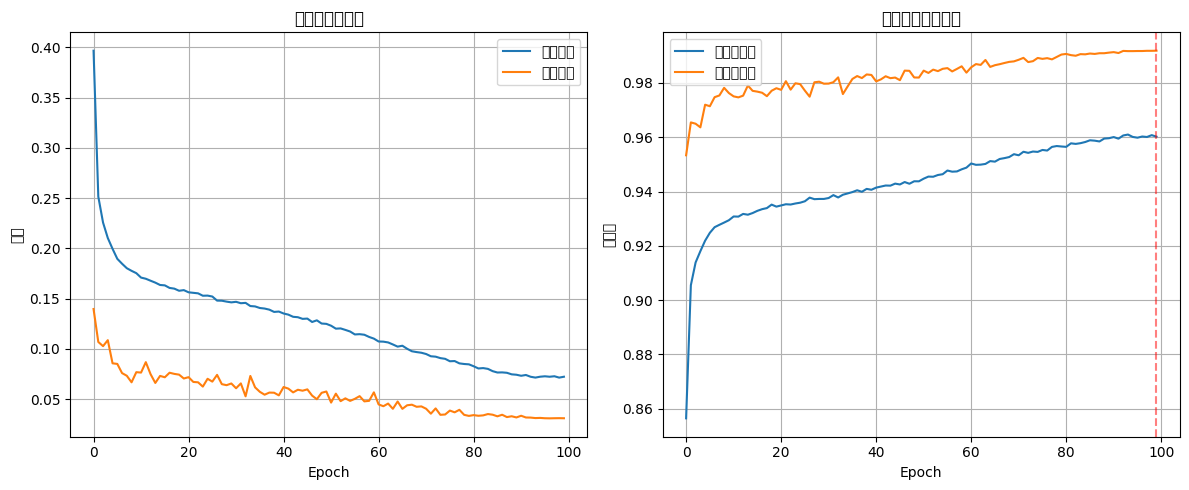

In [7]:
# %%
# 训练循环
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    """
    训练模型的主循环
    
    参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        scheduler: 学习率调度器
        num_epochs: 训练轮数
    
    返回:
        history: 包含训练和验证指标的历史记录
    """
    # 创建训练历史记录
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'best_epoch': 0,
        'best_val_acc': 0.0
    }
    
    # 训练开始时间
    start_time = time.time()
    
    # 最佳模型保存
    best_val_acc = 0.0
    
    # 训练循环
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # 训练一个epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # 验证
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        
        # 学习率调整
        scheduler.step()
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # 输出当前epoch训练情况
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} 完成")
        print(f"训练损失: {train_loss:.4f} | 训练准确率: {train_acc:.4f}")
        print(f"验证损失: {val_loss:.4f} | 验证准确率: {val_acc:.4f}")
        print(f"当前学习率: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"本轮用时: {epoch_time:.2f}秒")
        
        # 保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            history['best_val_acc'] = best_val_acc
            history['best_epoch'] = epoch + 1
            
            torch.save(model.state_dict(), Config.BEST_MODEL_PATH)
            print(f"✓ 模型已保存为 {Config.BEST_MODEL_PATH} (验证准确率提高: {best_val_acc:.4f})")
        
        # 早停检查
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\n早停机制触发，在Epoch {epoch+1}停止训练")
            break
    
    # 训练结束时间
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"\n训练完成! 总用时: {int(hours)}小时 {int(minutes)}分钟 {int(seconds)}秒")
    print(f"最佳验证准确率: {best_val_acc:.4f} (在Epoch {history['best_epoch']})")
    
    # 保存最终模型
    torch.save(model.state_dict(), Config.FINAL_MODEL_PATH)
    print(f"最终模型已保存为 {Config.FINAL_MODEL_PATH}")
    
    return history

# 执行训练
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=Config.NUM_EPOCHS
)

# 可视化训练历史
def plot_training_history(history):
    """绘制训练和验证的损失和准确率曲线"""
    plt.figure(figsize=(12, 5))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='训练损失')
    plt.plot(history['val_loss'], label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.title('训练和验证损失')
    plt.legend()
    plt.grid(True)
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='训练准确率')
    plt.plot(history['val_acc'], label='验证准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.title('训练和验证准确率')
    plt.legend()
    plt.grid(True)
    
    # 标记最佳epoch
    best_epoch = history['best_epoch'] - 1
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# 可视化训练历史
plot_training_history(training_history)


开始模型评估...


验证中:   0%|          | 0/844 [00:00<?, ?it/s]


===== 模型评估结果 =====
准确率 (Accuracy): 0.9919
精确率 (Precision): 0.9919
召回率 (Recall): 0.9919
F1值 (F1 Score): 0.9919

各类别指标:
       类别       精确率       召回率       F1值
0    call  0.993340  0.994333  0.993836
1    fist  0.992351  0.994998  0.993673
2    like  0.991009  0.992331  0.991669
3      ok  0.989051  0.993998  0.991518
4     one  0.986297  0.983667  0.984980
5    palm  0.997664  0.996666  0.997164
6    rock  0.994627  0.988322  0.991464
7   three  0.993320  0.991995  0.992657
8  two_up  0.989344  0.990664  0.990003


/tmp/ipykernel_50413/3755706594.py:90: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:90: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:90: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:90: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:90: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:90: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:90: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.

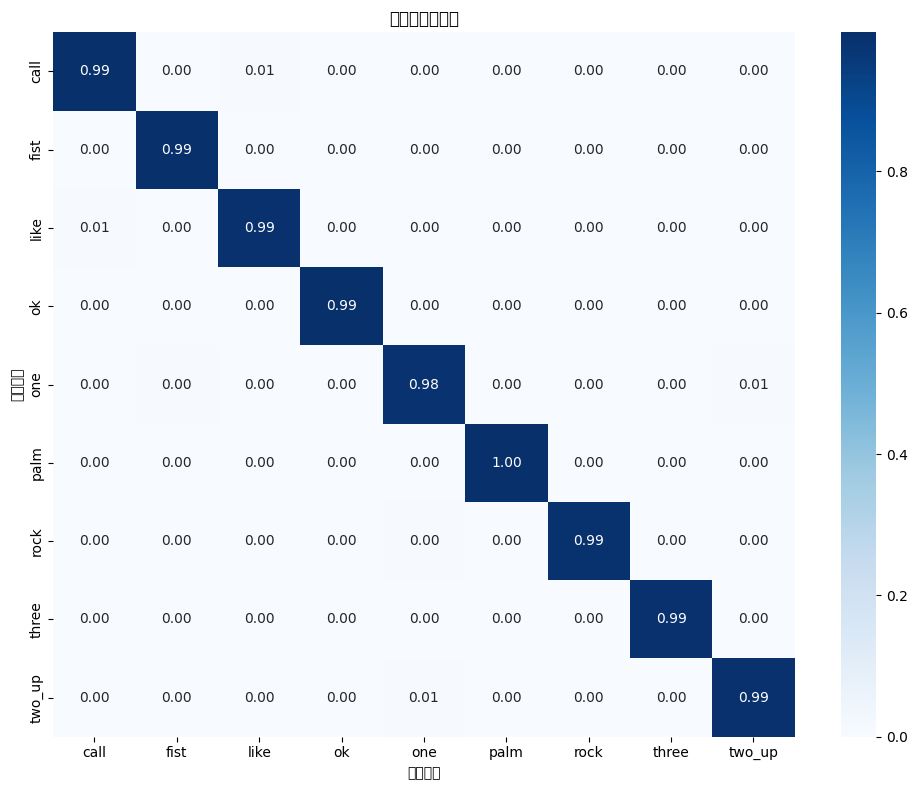

/tmp/ipykernel_50413/3755706594.py:113: UserWarning: Glyph 25163 (\N{CJK UNIFIED IDEOGRAPH-624B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:113: UserWarning: Glyph 21183 (\N{CJK UNIFIED IDEOGRAPH-52BF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:113: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:113: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:113: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:113: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50413/3755706594.py:113: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from current font.

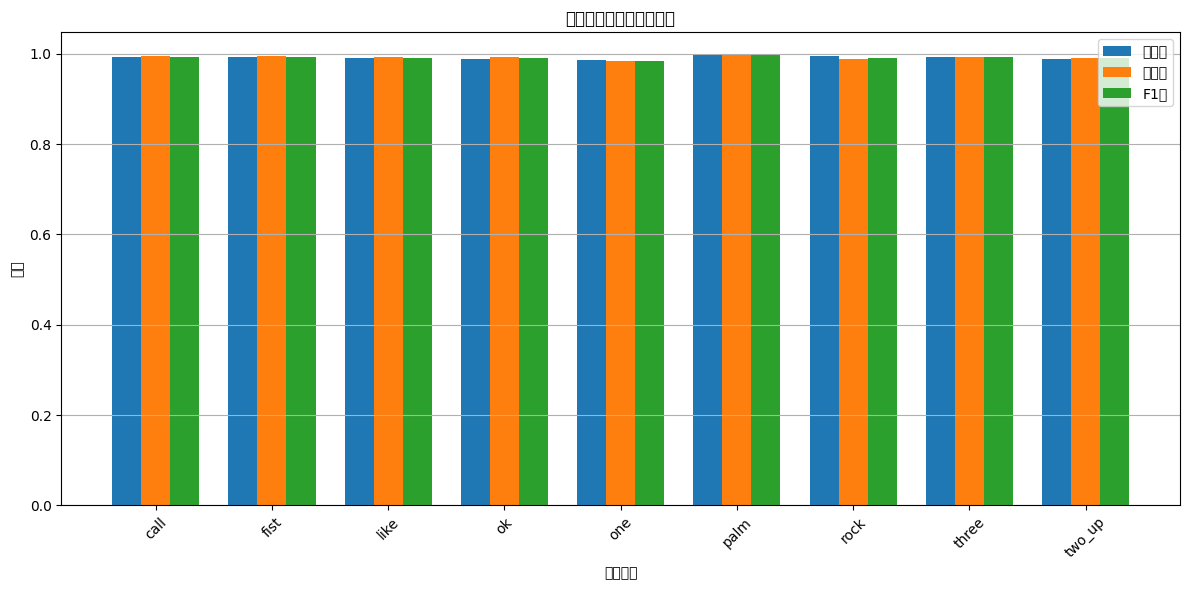

In [8]:
# %%
# 模型评估
def evaluate_model(model, dataloader, criterion, device):
    """
    全面评估模型性能
    
    参数:
        model: 要评估的模型
        dataloader: 数据加载器
        criterion: 损失函数
        device: 计算设备
    
    返回:
        评估指标和预测结果
    """
    print("开始模型评估...")
    
    # 加载最佳模型
    model.load_state_dict(torch.load(Config.BEST_MODEL_PATH))
    model.eval()
    
    # 获取验证集上的损失、准确率和预测
    val_loss, val_acc, all_preds, all_labels = validate(model, dataloader, criterion, device)
    
    # 计算评估指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # 输出评估结果
    print("\n===== 模型评估结果 =====")
    print(f"准确率 (Accuracy): {accuracy:.4f}")
    print(f"精确率 (Precision): {precision:.4f}")
    print(f"召回率 (Recall): {recall:.4f}")
    print(f"F1值 (F1 Score): {f1:.4f}")
    
    # 计算混淆矩阵
    cm = confusion_matrix(all_labels, all_preds)
    
    # 每个类别的精确率、召回率和F1值
    print("\n各类别指标:")
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    class_metrics = pd.DataFrame({
        '类别': Config.CLASSES,
        '精确率': precision_per_class,
        '召回率': recall_per_class,
        'F1值': f1_per_class
    })
    
    print(class_metrics)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels,
        'class_metrics': class_metrics
    }

# 执行评估
eval_results = evaluate_model(model, val_loader, criterion, device)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, class_names):
    """绘制混淆矩阵热图"""
    plt.figure(figsize=(10, 8))
    
    # 归一化混淆矩阵
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    plt.title('归一化混淆矩阵')
    plt.ylabel('真实类别')
    plt.xlabel('预测类别')
    plt.tight_layout()
    plt.show()

# 绘制混淆矩阵
plot_confusion_matrix(eval_results['confusion_matrix'], Config.CLASSES)

# 绘制各类别性能比较
def plot_class_metrics(class_metrics):
    """绘制各类别的性能指标"""
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(Config.CLASSES))
    width = 0.25
    
    plt.bar(x - width, class_metrics['精确率'], width, label='精确率')
    plt.bar(x, class_metrics['召回率'], width, label='召回率')
    plt.bar(x + width, class_metrics['F1值'], width, label='F1值')
    
    plt.xlabel('手势类别')
    plt.ylabel('分数')
    plt.title('各手势类别性能指标比较')
    plt.xticks(x, Config.CLASSES, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()

# 绘制各类别性能比较
plot_class_metrics(eval_results['class_metrics'])

